In [1]:
import cvxpy as cp
import numpy as np

from abacus_simulator.forecaster import Forecaster
from instruments.instruments import Equity

In [2]:
# Create stocks
start = "2005-12-28"
end = "2022-07-11"
interval = "wk"
stock1 = Equity(
    ric="XOM", currency="USD", start_date=start, end_date=end, interval=interval
)
stock2 = Equity(
    ric="CVX", currency="USD", start_date=start, end_date=end, interval=interval
)
stock3 = Equity(
    ric="^GSPC", currency="USD", start_date=start, end_date=end, interval=interval
)
stock4 = Equity(
    ric="WFC", currency="USD", start_date=start, end_date=end, interval=interval
)
stock5 = Equity(
    ric="MSFT", currency="USD", start_date=start, end_date=end, interval=interval
)

In [3]:
instruments = [stock1, stock2, stock3, stock4, stock5]
forc = Forecaster(instruments=instruments, number_of_steps=5)
forecasted_returns = forc.forecast_returns()

 [0.07966349 0.83541521 0.09930475] True
 [0.06109371 0.79387629 0.18175313] False
 [0.02161618 0.68328501 0.43294249] False
 [0.04267142 0.84278157 0.19959429] False
 [0.02231843 0.85344123 0.09842483] True


In [4]:
for row in forecasted_returns:
    print(row*100)

[ 0.17522024 -0.04226988  0.02684653 -0.03002656 -0.13309249]
[ 0.09499433  0.13167483 -0.05028183 -0.1044066  -0.33538317]
[ 0.01780704  0.08921025  0.01222081 -0.01708068 -0.19707606]
[-0.32831414  0.07129041  0.16417404  0.13764769 -0.25271772]
[ 0.03196275  0.01865388 -0.01087417 -0.06332288 -0.12466083]


In [5]:
cash_returns = np.zeros(5)
cash_returns

array([0., 0., 0., 0., 0.])

In [6]:
forecasted_returns = np.vstack([cash_returns, forecasted_returns])

In [7]:
for row in forecasted_returns:
    print(np.round(row*100, 2))

[0. 0. 0. 0. 0.]
[ 0.18 -0.04  0.03 -0.03 -0.13]
[ 0.09  0.13 -0.05 -0.1  -0.34]
[ 0.02  0.09  0.01 -0.02 -0.2 ]
[-0.33  0.07  0.16  0.14 -0.25]
[ 0.03  0.02 -0.01 -0.06 -0.12]


In [8]:
number_of_assets = 6
number_of_steps = 5

In [95]:
Z = cp.Variable((number_of_assets, number_of_steps))
W = cp.Variable((number_of_assets, number_of_steps-1))
R = forecasted_returns
ones = np.ones(number_of_assets)
init_portfolio = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

cost = 0
constr = []

# Building the objective function.
for t in range(number_of_steps):
    if t == 0:
        cost += R[:,t].T @ Z[:,t]
    else:
        cost += R[:,t].T @ (W[:,t-1] + Z[:,t])

# Bulding cost & constraints.
for t in range(number_of_steps):    
    if t == 0:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  W[:,t] == init_portfolio + Z[:,t],
                  W[:,t] >= 0,
                  W[:,t] <= 1]
    else:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  ]
        if t < number_of_steps-1:
            constr += [W[:,t] == W[:,t-1] + Z[:,t],
                       W[:,t] >= 0,
                       W[:,t] <= 1]

In [96]:
problem = cp.Problem(cp.Maximize(cost), constr)

In [97]:
problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 21 09:09:51 PM: Your problem has 54 variables, 22 constraints, and 0 parameters.
(CVXPY) Aug 21 09:09:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 21 09:09:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 21 09:09:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 21 09:09:51 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 21 09:09:51 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Con

0.01441826164543238

In [98]:
print(W.value)

[[4.12247078e-10 5.61780342e-10 1.11360974e-09 9.99999995e-01]
 [9.99999998e-01 4.22997027e-10 8.36907667e-10 1.11495117e-09]
 [8.70589205e-10 9.99999982e-01 5.57736014e-10 3.37529160e-10]
 [2.33307886e-10 6.94528070e-09 6.33321213e-10 7.72734116e-10]
 [2.48847473e-10 9.50429166e-09 9.99999996e-01 1.51666122e-09]
 [2.88187843e-10 6.12301038e-10 7.16284170e-10 9.13407283e-10]]


In [99]:
print(Z.value)

[[-1.66666666e-01  1.49528772e-10  5.51825019e-10  9.99999994e-01
   1.00000000e+00]
 [ 8.33333331e-01 -9.99999998e-01  4.13906394e-10  2.78041140e-10
   9.99999999e-01]
 [-1.66666666e-01  9.99999981e-01 -9.99999981e-01 -2.20209190e-10
  -5.00000000e+00]
 [-1.66666666e-01  6.71196787e-09 -6.31196377e-09  1.39410537e-10
   9.99999999e-01]
 [-1.66666666e-01  9.25543977e-09  9.99999987e-01 -9.99999995e-01
   9.99999999e-01]
 [-1.66666666e-01  3.24108782e-10  1.03978772e-10  1.97120761e-10
   9.99999999e-01]]


In [130]:
for i in range(number_of_steps-1):
    print(np.sum(W.value[:,i]))

1.000000000000058
1.0000000000000888
1.0000000000001192
1.0000000000001343


In [ ]:
def power_utility(x: float, gamma: float) -> float:
    """Constant RRA utility function. Optimal for investments (source Jorgen).

    Args:
        x (float): variable value
        gamma (float): risk aversion parameter

    Raises:
        ValueError: if gamma is greater than 1.

    Returns:
        float: utility of x.
    """

    if gamma > 1:
        raise ValueError("Value of gamma is larger than 1.")
    if gamma != 0:
        return x ** gamma / gamma
    else:
        return np.log(x)

Without any constraints the portfolio simply invests eveything into the stock with the largest return.

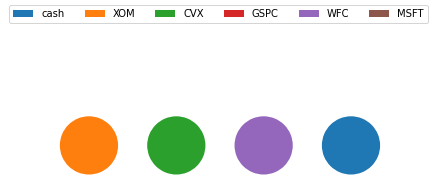

In [140]:
from matplotlib import pyplot as plt 
labels = 'cash', 'XOM', 'CVX', 'GSPC', 'WFC', 'MSFT'
explode = (0, 0.1, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
period_one = W.value[:,0]
period_two = W.value[:,1]
period_thr = W.value[:,2]
period_fou = W.value[:,3]

fig, ax = plt.subplots(1, 4)
ax[0].pie(period_one)
ax[1].pie(period_two)
ax[2].pie(period_thr)
ax[3].pie(period_fou)

fig.legend(labels, ncol=6)
plt.show()


Looking at the forecasts below we see why.

In [141]:
forecasted_returns

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.0017522 , -0.0004227 ,  0.00026847, -0.00030027, -0.00133092],
       [ 0.00094994,  0.00131675, -0.00050282, -0.00104407, -0.00335383],
       [ 0.00017807,  0.0008921 ,  0.00012221, -0.00017081, -0.00197076],
       [-0.00328314,  0.0007129 ,  0.00164174,  0.00137648, -0.00252718],
       [ 0.00031963,  0.00018654, -0.00010874, -0.00063323, -0.00124661]])

The objective function is maximized by investing the whole portfolio into 

Incorporating risk aversion

In [189]:
Z = cp.Variable((number_of_assets, number_of_steps))
W = cp.Variable((number_of_assets, number_of_steps-1))
R = forecasted_returns
ones = np.ones(number_of_assets)
init_portfolio = np.array([1, 0, 0, 0, 0, 0])

cost = 0
constr = []

# Building the objective function.
for t in range(number_of_steps):
    if t == 0:
        cost += R[:,t].T @ Z[:,t]
    else:
        cost += R[:,t].T @ (W[:,t-1] + Z[:,t])
cost = cp.power(cost, -2)/(-2)

# Bulding cost & constraints.
for t in range(number_of_steps):    
    if t == 0:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  W[:,t] == init_portfolio + Z[:,t],
                  W[:,t] >= 0,
                  W[:,t] <= 1]
    else:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  ]
        if t < number_of_steps-1:
            constr += [W[:,t] == W[:,t-1] + Z[:,t],
                       W[:,t] >= 0,
                       W[:,t] <= 1]

                

In [190]:
problem_risk_aversion = cp.Problem(cp.Maximize(cost), constr)

In [191]:
problem_risk_aversion.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 21 09:51:25 PM: Your problem has 54 variables, 22 constraints, and 0 parameters.
(CVXPY) Aug 21 09:51:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 21 09:51:25 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 21 09:51:25 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 21 09:51:25 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 21 09:51:25 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Con

/Users/axelnilsson/Desktop/Abacus/venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-2409.799699355677

In [192]:
print(W.value)

[[1.33089461e-09 1.65289107e-09 1.87691124e-09 9.99999993e-01]
 [9.99999989e-01 1.15055459e-09 1.97222868e-09 1.67802074e-09]
 [5.98292382e-09 9.99999980e-01 1.01782628e-09 3.73118625e-10]
 [1.56165562e-09 8.48847557e-09 1.69171967e-09 1.10354873e-09]
 [2.68625955e-10 7.22583103e-09 9.99999992e-01 3.03041156e-09]
 [1.79744410e-09 2.01336347e-09 1.37252359e-09 1.34482172e-09]]
